## Imports

In [1]:
import pandas as pd 
import numpy as np
import torch
import pybedtools
import pickle
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from statistics import *
from collections import Counter

import sklearn
from sklearn.preprocessing import *
from sklearn.feature_selection import *
from sklearn.model_selection import *
from sklearn.svm import *
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import *
from scipy import interp
from sksurv.nonparametric import kaplan_meier_estimator
from sksurv.preprocessing import OneHotEncoder
from sksurv.linear_model import CoxPHSurvivalAnalysis
from sksurv.metrics import concordance_index_censored
from lifelines.statistics import logrank_test
from lifelines import CoxPHFitter
from lifelines.utils import concordance_index

## Load METABRIC clinical file

In [2]:
metabric_clinical = pd.read_csv('clinical_METABRIC.tsv', sep='\t')
print("Original Shape: ", metabric_clinical.shape)
metabric_clinical = metabric_clinical.loc[(metabric_clinical['ER.Expr'] == '+') & (metabric_clinical['Her2.Expr'] == '-')]
print("Only ER+/HER2-: ", metabric_clinical.shape)
metabric_clinical = metabric_clinical[metabric_clinical.iC10.apply(lambda x: x in ['3','4ER+','7','8','1','2','6','9'])]
metabric_clinical = metabric_clinical.loc[metabric_clinical['Size'] == metabric_clinical['Size']]
metabric_clinical = metabric_clinical.loc[metabric_clinical['Grade'] == metabric_clinical['Grade']]
label = []
for index,row in metabric_clinical.iterrows():
    if row['iC10'] in ['3','4ER+','7','8']:
        label.append(0)
    elif row['iC10'] in ['1','2','6','9']:
        label.append(1)
metabric_clinical['label'] = label
#metabric_clinical = metabric_clinical.loc[(metabric_clinical['T'] > 1825) & (metabric_clinical['TDR'] > 1825)]
metabric_clinical['DeathBreast'] = metabric_clinical['DeathBreast'].astype('bool')
metabric_clinical['Lymph.Nodes.Positive'] = metabric_clinical['Lymph.Nodes.Positive'].astype('float')
metabric_clinical['LR'] = metabric_clinical['LR'].astype('bool')
metabric_clinical['DR'] = metabric_clinical['DR'].astype('bool')
metabric_clinical['TLDR'] = metabric_clinical[['TLR','TDR']].min(axis=1)
metabric_clinical['LDR'] = (metabric_clinical['LR'] | metabric_clinical['DR']).astype('bool')
metabric_clinical['TDLR'] = metabric_clinical[['T','TLR']].min(axis=1)
metabric_clinical['DLR'] = (metabric_clinical['DeathBreast'] | metabric_clinical['LR']).astype('bool')
metabric_clinical['TDDR'] = metabric_clinical[['T','TDR']].min(axis=1)
metabric_clinical['DDR'] = (metabric_clinical['DeathBreast'] | metabric_clinical['DR']).astype('bool')
metabric_clinical['TDLDR'] = metabric_clinical[['T','TLR','TDR']].min(axis=1)
metabric_clinical['DLDR'] = (metabric_clinical['DeathBreast'] | metabric_clinical['DR'] | metabric_clinical['LR']).astype('bool')

metabric_clinical.drop_duplicates(inplace=True)

print("Only ER+/HER2- in 8 IntClusts: ", metabric_clinical.shape)
display(metabric_clinical.head())

Original Shape:  (1980, 35)
Only ER+/HER2-:  (1398, 35)
Only ER+/HER2- in 8 IntClusts:  (1285, 44)


,METABRIC.ID,MATCHED.NORMAL.METABRIC.ID,Cohort,Age.At.Diagnosis,Breast.Tumour.Laterality,Date.Of.Diagnosis,Last.Followup.Status,NPI,ER.Status,Inferred.Menopausal.State,...,Complete.Rec.History,label,TLDR,LDR,TDLR,DLR,TDDR,DDR,TDLDR,DLDR
0,MB-0002,MB-0003,1,43.19,r,2000/12,a,4.020,pos,pre,...,YES,0,2539,False,2539,False,2539,False,2539,False
1,MB-0005,MB-0004,1,48.87,r,2001/02,d-d.s.,4.030,pos,pre,...,YES,0,4599,True,4911,True,4599,True,4599,True
2,MB-0006,MB-0007,1,47.68,r,2001/02,a,4.050,pos,pre,...,YES,1,4948,False,4948,False,4948,False,4948,False
3,MB-0010,MB-0011,1,78.77,l,2001/03,d-d.s.,4.062,pos,post,...,YES,0,88,True,234,True,88,True,88,True
4,MB-0014,MB-0015,1,56.45,r,2001/04,a,4.020,pos,post,...,YES,0,4930,False,4930,False,4930,False,4930,False


## Load CNA data

### Load segmented CNA file

In [3]:
metabric_iclust = pd.read_csv('CNA_0.005eps_metabric.tsv', sep='\t')
metabric_iclust.rename(columns={metabric_iclust.columns[0]: 'sample'}, inplace=True)
display(metabric_iclust.head())
display(metabric_iclust.shape)

,sample,chr1.51599-72034,chr1.72034-75800,chr1.75800-88452,chr1.88452-88466,chr1.88466-218570,chr1.218570-218593,chr1.218593-218939,chr1.218939-219037,chr1.219037-219483,...,chr22.41285376-41285697,chr22.41285697-43029372,chr22.43029372-43032379,chr22.43032379-45779329,chr22.45779329-45780363,chr22.45780363-45780734,chr22.45780734-47538878,chr22.47538878-49319975,chr22.49319975-49320621,chr22.49320621-49581322
0,MB-0000,-0.112070,0.571503,0.571503,0.571503,0.571503,0.571503,0.571503,0.571503,0.571503,...,-0.050073,-0.050073,-0.050073,-0.050073,-0.050073,-0.050073,-0.050073,-0.050073,-0.050073,-0.050073
1,MB-0002,0.002596,0.002596,0.002596,0.002596,0.002596,0.002596,0.002596,0.002596,0.002596,...,-0.265810,-0.265810,-0.265810,-0.265810,-0.265810,-0.265810,-0.265810,-0.265810,-0.265810,-0.265810
2,MB-0005,0.220760,0.220760,0.220760,0.220760,0.220760,0.220760,0.220760,0.220760,0.220760,...,-0.041826,-0.041826,-0.041826,-0.041826,-0.041826,-0.041826,-0.041826,-0.041826,-0.041826,-0.041826
3,MB-0006,-0.071814,-0.071814,-0.071814,-0.071814,-0.071814,-0.071814,-0.071814,-0.071814,-0.071814,...,-0.310061,-0.310061,-0.310061,-0.310061,-0.310061,-0.310061,-0.310061,-0.310061,-0.310061,-0.310061
4,MB-0008,0.178845,0.178845,0.178845,0.178845,0.178845,0.178845,0.178845,0.178845,0.178845,...,-0.361051,-0.274476,-0.122731,-0.274476,-0.274476,-0.274476,-0.274476,-0.274476,-0.055292,-0.055292


(1360, 4795)

### Merge CNA and clinical tables

In [4]:
metabric_iclust_joined = metabric_iclust.merge(metabric_clinical, how='inner', left_on='sample', right_on='METABRIC.ID')#right_on="ID")
metabric_iclust_joined = metabric_iclust_joined.drop('METABRIC.ID', axis=1)
display(metabric_iclust_joined.head())
display(metabric_iclust_joined.shape)

,sample,chr1.51599-72034,chr1.72034-75800,chr1.75800-88452,chr1.88452-88466,chr1.88466-218570,chr1.218570-218593,chr1.218593-218939,chr1.218939-219037,chr1.219037-219483,...,Complete.Rec.History,label,TLDR,LDR,TDLR,DLR,TDDR,DDR,TDLDR,DLDR
0,MB-0000,-0.112070,0.571503,0.571503,0.571503,0.571503,0.571503,0.571503,0.571503,0.571503,...,YES,0,4215,False,4215,False,4215,False,4215,False
1,MB-0002,0.002596,0.002596,0.002596,0.002596,0.002596,0.002596,0.002596,0.002596,0.002596,...,YES,0,2539,False,2539,False,2539,False,2539,False
2,MB-0005,0.220760,0.220760,0.220760,0.220760,0.220760,0.220760,0.220760,0.220760,0.220760,...,YES,0,4599,True,4911,True,4599,True,4599,True
3,MB-0006,-0.071814,-0.071814,-0.071814,-0.071814,-0.071814,-0.071814,-0.071814,-0.071814,-0.071814,...,YES,1,4948,False,4948,False,4948,False,4948,False
4,MB-0008,0.178845,0.178845,0.178845,0.178845,0.178845,0.178845,0.178845,0.178845,0.178845,...,YES,1,564,True,564,True,941,True,564,True


(1285, 4838)

## Prepare for Model Training

### Extract Features

In [5]:
pd.set_option('display.max_columns', 40)
metabric_iclust_joined = metabric_iclust_joined.loc[metabric_iclust_joined['Size'] == metabric_iclust_joined['Size']]
metabric_iclust_joined = metabric_iclust_joined.loc[metabric_iclust_joined['Grade'] == metabric_iclust_joined['Grade']]
X = metabric_iclust_joined.drop('label', axis=1)
X = X.drop('sample', axis=1)
X = X.iloc[:,:4794]
X['Age.At.Diagnosis'] = metabric_iclust_joined['Age.At.Diagnosis']
X['Size'] = metabric_iclust_joined['Size']
X['Grade'] = metabric_iclust_joined['Grade']
X['Lymph.Nodes.Positive']  = metabric_iclust_joined['Lymph.Nodes.Positive']
display(X.shape)
display(X.head())

(1285, 4798)

,chr1.51599-72034,chr1.72034-75800,chr1.75800-88452,chr1.88452-88466,chr1.88466-218570,chr1.218570-218593,chr1.218593-218939,chr1.218939-219037,chr1.219037-219483,chr1.219483-219541,chr1.219541-225534,chr1.225534-225802,chr1.225802-346307,chr1.346307-394035,chr1.394035-524415,chr1.524415-593454,chr1.593454-1617779,chr1.1617779-1618687,chr1.1618687-1631964,chr1.1631964-1677448,...,chr22.37733740-38924519,chr22.38924519-38930433,chr22.38930433-41227227,chr22.41227227-41229385,chr22.41229385-41272907,chr22.41272907-41285376,chr22.41285376-41285697,chr22.41285697-43029372,chr22.43029372-43032379,chr22.43032379-45779329,chr22.45779329-45780363,chr22.45780363-45780734,chr22.45780734-47538878,chr22.47538878-49319975,chr22.49319975-49320621,chr22.49320621-49581322,Age.At.Diagnosis,Size,Grade,Lymph.Nodes.Positive
0,-0.112070,0.571503,0.571503,0.571503,0.571503,0.571503,0.571503,0.571503,0.571503,0.571503,0.571503,0.571503,0.571503,0.004068,0.004068,0.004068,-0.050073,-0.050073,-0.050073,-0.050073,...,-0.112070,-0.112070,-0.112070,-0.050073,-0.050073,-0.050073,-0.050073,-0.050073,-0.050073,-0.050073,-0.050073,-0.050073,-0.050073,-0.050073,-0.050073,-0.050073,75.65,22.0,3.0,10.0
1,0.002596,0.002596,0.002596,0.002596,0.002596,0.002596,0.002596,0.002596,0.002596,0.002596,0.002596,0.002596,0.002596,0.002596,0.002596,0.002596,0.002596,0.002596,0.002596,0.002596,...,-0.265810,-0.265810,-0.265810,-0.265810,-0.265810,-0.265810,-0.265810,-0.265810,-0.265810,-0.265810,-0.265810,-0.265810,-0.265810,-0.265810,-0.265810,-0.265810,43.19,10.0,3.0,0.0
2,0.220760,0.220760,0.220760,0.220760,0.220760,0.220760,0.220760,0.220760,0.220760,0.220760,0.220760,0.220760,0.220760,0.220760,0.220760,0.220760,-0.041826,-0.041826,-0.041826,-0.041826,...,-0.041826,-0.041826,-0.041826,-0.041826,-0.041826,-0.041826,-0.041826,-0.041826,-0.041826,-0.041826,-0.041826,-0.041826,-0.041826,-0.041826,-0.041826,-0.041826,48.87,15.0,2.0,1.0
3,-0.071814,-0.071814,-0.071814,-0.071814,-0.071814,-0.071814,-0.071814,-0.071814,-0.071814,-0.071814,-0.071814,-0.071814,-0.071814,-0.071814,-0.071814,-0.071814,-0.071814,-0.071814,-0.071814,-0.071814,...,-0.310061,-0.310061,-0.310061,-0.310061,-0.310061,-0.310061,-0.310061,-0.310061,-0.310061,-0.310061,-0.310061,-0.310061,-0.310061,-0.310061,-0.310061,-0.310061,47.68,25.0,2.0,3.0
4,0.178845,0.178845,0.178845,0.178845,0.178845,0.178845,0.178845,0.178845,0.178845,0.178845,0.178845,0.178845,0.178845,0.178845,0.178845,0.178845,-0.274476,-0.437599,-0.437599,-0.437599,...,-0.274476,-0.437599,-0.437599,-0.361051,-0.361051,-0.361051,-0.361051,-0.274476,-0.122731,-0.274476,-0.274476,-0.274476,-0.274476,-0.274476,-0.055292,-0.055292,76.97,40.0,3.0,8.0


### Extract Targets

In [6]:
Y = metabric_iclust_joined.iloc[:,4795:]
# Y['DR'] = Y['DR'].astype(int)
# Y['DDR'] = Y['DDR'].astype(int)
display(Y.head())
display(Y.shape)

,MATCHED.NORMAL.METABRIC.ID,Cohort,Age.At.Diagnosis,Breast.Tumour.Laterality,Date.Of.Diagnosis,Last.Followup.Status,NPI,ER.Status,Inferred.Menopausal.State,Lymph.Nodes.Positive,Breast.Surgery,CT,HT,RT,Grade,Size,Histological.Type,Stage,Cellularity,DeathBreast,...,LR,TDR,DR,HER2.SNP6,iC10,Pam50Subtype,ER.Expr,Her2.Expr,PR.Expr,ClaudinSubtype,Complete.Rec.History,label,TLDR,LDR,TDLR,DLR,TDDR,DDR,TDLDR,DLDR
0,NaN,1,75.65,r,2000/12,a,6.044,pos,post,10.0,MASTECTOMY,NO/NA,TAM/AI,CW,3.0,22.0,IDC,2.0,NaN,False,...,False,4215,False,NEUT,4ER+,Normal,+,-,-,claudin-low,YES,0,4215,False,4215,False,4215,False,4215,False
1,MB-0003,1,43.19,r,2000/12,a,4.020,pos,pre,0.0,BREAST CONSERVING,NO/NA,TAM,CW,3.0,10.0,IDC,1.0,high,False,...,False,2539,False,NEUT,4ER+,LumA,+,-,+,LumA,YES,0,2539,False,2539,False,2539,False,2539,False
2,MB-0004,1,48.87,r,2001/02,d-d.s.,4.030,pos,pre,1.0,MASTECTOMY,OTHER,TAM,NO/NA,2.0,15.0,IDC,2.0,high,True,...,False,4599,True,NEUT,3,LumB,+,-,+,LumB,YES,0,4599,True,4911,True,4599,True,4599,True
3,MB-0007,1,47.68,r,2001/02,a,4.050,pos,pre,3.0,MASTECTOMY,OTHER,AI,CW,2.0,25.0,IDC,2.0,moderate,False,...,False,4948,False,NEUT,9,LumB,+,-,+,LumB,YES,1,4948,False,4948,False,4948,False,4948,False
4,NaN,1,76.97,r,2001/03,d-d.s.,6.080,pos,post,8.0,MASTECTOMY,CAPE,TAM,CW-NODAL,3.0,40.0,IDC,2.0,high,True,...,True,941,True,NEUT,9,LumB,+,-,+,LumB,YES,1,564,True,564,True,941,True,564,True


(1285, 43)

## Neural Network

### Select Number of Hidden Layers

In [7]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

best_num_hidden = []

for train_index, test_index in cv.split(X, Y['label']):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    Y_train, Y_test = Y.iloc[train_index], Y.iloc[test_index]
    
    inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
    
    hidden = [100, 200, 300, 400, 500]
    
    best_num_hidden_ = 0
    
    auroc_ = []
    auprc_ = []
    nll_ = []
    f1_ = []
    precision_ = []
    recall_ = []
        
    for num_hidden in hidden:
        
        _auroc_ = []
        _auprc_ = []
        _nll_ = []
        _f1_ = []
        _precision_ = []
        _recall_ = []
        
        print("Num Hidden: ", num_hidden)
        
        fold = 1
        
        for inner_train, inner_test in inner_cv.split(X_train, Y_train['label']):
            
            print("Fold: ", fold)
            
            fold += 1
        
            X_inner_train, X_inner_test = X_train.iloc[inner_train], X_train.iloc[inner_test]
            Y_inner_train, Y_inner_test = Y_train.iloc[inner_train], Y_train.iloc[inner_test]

            scaler = StandardScaler().fit(X_inner_train)

            X_inner_train = np.array(scaler.transform(X_inner_train))                                                                                                                                                                                                                     
            X_inner_test = np.array(scaler.transform(X_inner_test))                 
            Y_inner_train = np.array(Y_inner_train['label'])                        
            Y_inner_test = np.array(Y_inner_test['label'])                          
            Y_inner_train = np.expand_dims(Y_inner_train, axis=1)                   
            Y_inner_test = np.expand_dims(Y_inner_test, axis=1)                     

            pos = Y_inner_train == 1                                                
            pos_ratio = 1 / (len(Y_inner_train[pos]) / len(Y_inner_train))          

            X_inner_train = torch.from_numpy(X_inner_train).type(torch.FloatTensor) 
            X_inner_test = torch.from_numpy(X_inner_test).type(torch.FloatTensor)   
            Y_inner_train = torch.from_numpy(Y_inner_train).type(torch.FloatTensor) 
            Y_inner_test = torch.from_numpy(Y_inner_test).type(torch.FloatTensor)   

            batch_size = 257                                                        
            input_size = X_inner_train.shape[1]                                     
            output_size = Y_inner_train.shape[1]                                    

            num_hidden = 200                                                        

            model = torch.nn.Sequential(                                            
                    torch.nn.Linear(input_size, num_hidden),                        
                    torch.nn.BatchNorm1d(num_hidden),                               
                    torch.nn.ReLU(),                                                
                    torch.nn.Dropout(p=0.5),                                        
                    torch.nn.Linear(num_hidden, output_size),)                      

            class_weight=torch.FloatTensor([pos_ratio])                             
            loss_fn = torch.nn.BCEWithLogitsLoss(pos_weight=class_weight)           

            learning_rate = 0.0002                                                  

            optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)      

            lowest_val_loss = 100                                                   
            last_improvement = 0

            while last_improvement < 5:                                             

                model.train()                                                       

                for i in range(0,Y_inner_train.shape[0]-batch_size,batch_size):     

                    optimizer.zero_grad()                                           

                    y_pred = model(X_inner_train[i:i+batch_size])                   

                    l1_reg = None                                                   
                    for W in model.parameters():                                    
                        if l1_reg is None:                                          
                            l1_reg = W.norm(p=1)                                    
                        else:                                                       
                            l1_reg = l1_reg + W.norm(p=1)                           

                    l2_reg = None                                                   
                    for W in model.parameters():                                    
                        if l2_reg is None:                                          
                            l2_reg = W.norm(2)                                      
                        else:                                                       
                            l2_reg = l2_reg + W.norm(2)                             

                    loss = loss_fn(y_pred, Y_inner_train[i:i+batch_size]) + 0.002 * l1_reg

                    optimizer.zero_grad()                                           
                    loss.backward()                                                 

                    optimizer.step()                                                

                model.eval()                                                        

                val_pred = model(X_inner_test)                                      
                val_loss = loss_fn(val_pred, Y_inner_test)                          

                if val_loss < lowest_val_loss:                                      
                    last_improvement = 0                                            
                    lowest_val_loss = val_loss                                      
                    torch.save(model.state_dict(), 'best_params')                   
                else:                                                               
                    last_improvement += 1
            
            model.load_state_dict(torch.load('best_params'))
            model.eval()
            
            val_pred = model(X_inner_test)                                                                                                                                                                                                                                    
            val_loss = loss_fn(val_pred, Y_inner_test)                          
                                                                                
            sig = torch.nn.Sigmoid()                                            
            fold_preds = sig(val_pred)                                          
            fold_preds = fold_preds.detach().numpy()                            
            fold_preds_bin = np.zeros((fold_preds.shape))                       
                                                                                
            for i in range(fold_preds.shape[0]):                                
                fold_preds[i,0] = fold_preds[i,0]                               
                if fold_preds[i,0] < 0.5:                                       
                    fold_preds_bin[i,0] = 0                                     
                else:                                                           
                    fold_preds_bin[i,0] = 1                                     
                                                                                
            Y_inner_test = Y_inner_test.detach().numpy()                        
                                                                                
            _auroc_.append(roc_auc_score(Y_inner_test, fold_preds))               
            _auprc_.append(average_precision_score(Y_inner_test, fold_preds))     
            _nll_.append(log_loss(Y_inner_test, fold_preds))                      
                                                                                
            _f1_.append(f1_score(Y_inner_test, fold_preds_bin))                   
            _precision_.append(precision_score(Y_inner_test, fold_preds_bin))     
            _recall_.append(recall_score(Y_inner_test, fold_preds_bin))
                
        auroc_.append(mean(_auroc_))
        auprc_.append(mean(_auprc_))
        nll_.append(mean(_nll_))
        f1_.append(mean(_f1_))
        precision_.append(mean(_precision_))
        recall_.append(mean(_recall_))
        

    scoring = auprc_
    best_num_hidden_ = hidden[scoring.index(max(scoring))]
    best_num_hidden.append(best_num_hidden_)
    
    print()
    print("Best Num Hidden: ", best_num_hidden_)
    print()
    
modes = Counter(best_num_hidden).most_common()
if modes[0][1] > modes[1][1]:
    modes = modes[0][0]
elif modes[0][0] < modes[1][0]:
    modes = modes[0][0]
else:
    modes = modes[1][0]

overall_best_num_hidden = modes
num_hidden = overall_best_num_hidden

print("Overall best number of hidden layers: ", overall_best_num_hidden)

Num Hidden:  100
Fold:  1
Fold:  2
Fold:  3
Fold:  4
Fold:  5
Num Hidden:  200
Fold:  1
Fold:  2
Fold:  3
Fold:  4
Fold:  5
Num Hidden:  300
Fold:  1
Fold:  2
Fold:  3
Fold:  4
Fold:  5
Num Hidden:  400
Fold:  1
Fold:  2
Fold:  3
Fold:  4
Fold:  5
Num Hidden:  500
Fold:  1
Fold:  2
Fold:  3
Fold:  4
Fold:  5

Best Num Hidden:  200

Num Hidden:  100
Fold:  1
Fold:  2
Fold:  3
Fold:  4
Fold:  5
Num Hidden:  200
Fold:  1
Fold:  2
Fold:  3
Fold:  4
Fold:  5
Num Hidden:  300
Fold:  1
Fold:  2
Fold:  3
Fold:  4
Fold:  5
Num Hidden:  400
Fold:  1
Fold:  2
Fold:  3
Fold:  4
Fold:  5
Num Hidden:  500
Fold:  1
Fold:  2
Fold:  3
Fold:  4
Fold:  5

Best Num Hidden:  100

Num Hidden:  100
Fold:  1
Fold:  2
Fold:  3
Fold:  4
Fold:  5
Num Hidden:  200
Fold:  1
Fold:  2
Fold:  3
Fold:  4
Fold:  5
Num Hidden:  300
Fold:  1
Fold:  2
Fold:  3
Fold:  4
Fold:  5
Num Hidden:  400
Fold:  1
Fold:  2
Fold:  3
Fold:  4
Fold:  5
Num Hidden:  500
Fold:  1
Fold:  2
Fold:  3
Fold:  4
Fold:  5

Best Num Hidden:  300

### AUROC

Fold: 	 1
Fold: 	 2
Fold: 	 3
Fold: 	 4
Fold: 	 5


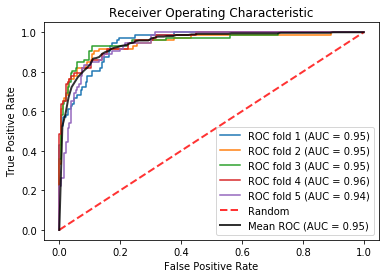

In [32]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

j = 0
for train_index, test_index in cv.split(X, Y['label']):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    Y_train, Y_test = Y.iloc[train_index], Y.iloc[test_index]
    
    scaler = StandardScaler().fit(X_train)
    X_train = np.array(scaler.transform(X_train))
    X_test = np.array(scaler.transform(X_test))
    Y_train = np.array(Y_train['label'])
    Y_test = np.array(Y_test['label'])
    Y_train = np.expand_dims(Y_train, axis=1)
    Y_test = np.expand_dims(Y_test, axis=1)
    
    pos = Y_train == 0
    pos_ratio = 1 / (len(Y_train[pos]) / len(Y_train))
    
    X_train = torch.from_numpy(X_train).type(torch.FloatTensor)
    X_test = torch.from_numpy(X_test).type(torch.FloatTensor)
    Y_train = torch.from_numpy(Y_train).type(torch.FloatTensor)
    Y_test = torch.from_numpy(Y_test).type(torch.FloatTensor)
    
    batch_size = 128
    input_size = X_train.shape[1]
    output_size = Y_train.shape[1]
    
    num_hidden = overall_best_num_hidden
    
    model = torch.nn.Sequential(
            torch.nn.Linear(input_size, num_hidden),        
            torch.nn.BatchNorm1d(num_hidden),
            torch.nn.ReLU(),
            torch.nn.Dropout(p=0.5),
            torch.nn.Linear(num_hidden, output_size),)
    
    class_weight=torch.FloatTensor([pos_ratio])
    loss_fn = torch.nn.BCEWithLogitsLoss(pos_weight=class_weight)

    loss_fn = torch.nn.BCEWithLogitsLoss()

    learning_rate = 0.0002

    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
        
    lowest_val_loss = 100
    last_improvement = 0

    while last_improvement < 5:

        model.train()
            
        for i in range(0,Y_train.shape[0]-batch_size,batch_size):

            optimizer.zero_grad()
                
            y_pred = model(X_train[i:i+batch_size])
                
            l1_reg = None
            for W in model.parameters():
                if l1_reg is None:
                    l1_reg = W.norm(p=1)
                else:
                    l1_reg = l1_reg + W.norm(p=1)
                        
            l2_reg = None
            for W in model.parameters():
                if l2_reg is None:
                    l2_reg = W.norm(2)
                else:
                    l2_reg = l2_reg + W.norm(2)

            loss = loss_fn(y_pred, Y_train[i:i+batch_size]) + 0.001 * l1_reg

            optimizer.zero_grad()
            loss.backward()

            optimizer.step()
                
        model.eval()
            
        val_pred = model(X_test)
        val_loss = loss_fn(val_pred, Y_test)
                        
        if val_loss < lowest_val_loss:
            last_improvement = 0
            lowest_val_loss = val_loss
            torch.save(model.state_dict(), 'best_params')    
        else:
            last_improvement += 1
                        
    model.load_state_dict(torch.load('best_params'))
    model.eval()
    train_pred = model(X_train)
    train_loss = loss_fn(train_pred, Y_train)    
            
    val_pred = model(X_test)
    val_loss = loss_fn(val_pred, Y_test)
                
    sig = torch.nn.Sigmoid()
    fold_preds = sig(val_pred)
    fold_preds = fold_preds.detach().numpy()
    fold_preds_bin = np.zeros((fold_preds.shape))
    
    for i in range(fold_preds.shape[0]):
        fold_preds[i,0] = fold_preds[i,0]
        if fold_preds[i,0] <= 0.5:
            fold_preds_bin[i,0] = 0
        else:
            fold_preds_bin[i,0] = 1
        
    Y_test = Y_test.detach().numpy()
    
    fpr, tpr, thresholds = roc_curve(Y_test, fold_preds)
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, #lw=1, alpha=0.3,
             label='ROC fold %d (AUC = %0.2f)' % (j+1, roc_auc))
    j += 1
    print("Fold: \t", j)
    
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Random', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='black',
         label=r'Mean ROC (AUC = %0.2f)' % (mean_auc),
         lw=2, alpha=.8)

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

### AUPRC

Fold: 	 1
Fold: 	 2
Fold: 	 3
Fold: 	 4
Fold: 	 5


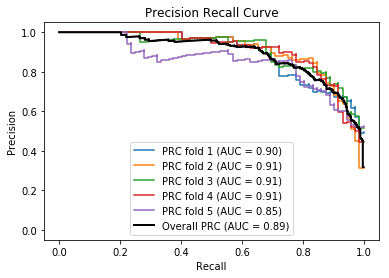

In [33]:
y_real = []
y_proba = []
auprcs = []

j = 0
for train_index, test_index in cv.split(X, Y['label']):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    Y_train, Y_test = Y.iloc[train_index], Y.iloc[test_index]
    
    scaler = StandardScaler().fit(X_train)
    X_train = np.array(scaler.transform(X_train))
    X_test = np.array(scaler.transform(X_test))
    Y_train = np.array(Y_train['label'])
    Y_test = np.array(Y_test['label'])
    Y_train = np.expand_dims(Y_train, axis=1)
    Y_test = np.expand_dims(Y_test, axis=1)
    
    pos = Y_train == 0
    pos_ratio = 1 / (len(Y_train[pos]) / len(Y_train))
    
    X_train = torch.from_numpy(X_train).type(torch.FloatTensor)
    X_test = torch.from_numpy(X_test).type(torch.FloatTensor)
    Y_train = torch.from_numpy(Y_train).type(torch.FloatTensor)
    Y_test = torch.from_numpy(Y_test).type(torch.FloatTensor)
    
    batch_size = 128
    input_size = X_train.shape[1]
    output_size = Y_train.shape[1]

    num_hidden = overall_best_num_hidden
    
    model = torch.nn.Sequential(
            torch.nn.Linear(input_size, num_hidden),        
            torch.nn.BatchNorm1d(num_hidden),
            torch.nn.ReLU(),
            torch.nn.Dropout(p=0.5),
            torch.nn.Linear(num_hidden, output_size),)
    
    class_weight=torch.FloatTensor([pos_ratio])
    loss_fn = torch.nn.BCEWithLogitsLoss(pos_weight=class_weight)

    loss_fn = torch.nn.BCEWithLogitsLoss()

    learning_rate = 0.0002

    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
        
    lowest_val_loss = 100
    last_improvement = 0

    while last_improvement < 5:

        model.train()
            
        for i in range(0,Y_train.shape[0]-batch_size,batch_size):

            optimizer.zero_grad()
                
            y_pred = model(X_train[i:i+batch_size])
                
            l1_reg = None
            for W in model.parameters():
                if l1_reg is None:
                    l1_reg = W.norm(p=1)
                else:
                    l1_reg = l1_reg + W.norm(p=1)
                        
            l2_reg = None
            for W in model.parameters():
                if l2_reg is None:
                    l2_reg = W.norm(2)
                else:
                    l2_reg = l2_reg + W.norm(2)

            loss = loss_fn(y_pred, Y_train[i:i+batch_size]) + 0.001 * l1_reg

            optimizer.zero_grad()
            loss.backward()

            optimizer.step()
                
        model.eval()
            
        val_pred = model(X_test)
        val_loss = loss_fn(val_pred, Y_test)
                        
        if val_loss < lowest_val_loss:
            last_improvement = 0
            lowest_val_loss = val_loss
            torch.save(model.state_dict(), 'best_params')    
        else:
            last_improvement += 1
                        
    model.load_state_dict(torch.load('best_params'))
    model.eval()
    train_pred = model(X_train)
    train_loss = loss_fn(train_pred, Y_train)    
            
    val_pred = model(X_test)
    val_loss = loss_fn(val_pred, Y_test)
                
    sig = torch.nn.Sigmoid()
    fold_preds = sig(val_pred)
    fold_preds = fold_preds.detach().numpy()
    fold_preds_bin = np.zeros((fold_preds.shape))
    
    for i in range(fold_preds.shape[0]):
        fold_preds[i,0] = fold_preds[i,0]
        if fold_preds[i,0] <= 0.5:
            fold_preds_bin[i,0] = 0
        else:
            fold_preds_bin[i,0] = 1
        
    Y_test = Y_test.detach().numpy()
    
    precision, recall, _ = precision_recall_curve(Y_test, fold_preds)
    auprc = auc(recall, precision)
    lab = 'PRC fold %d (AUC = %0.2f)' % (j+1, auprc)
    plt.step(recall, precision, label=lab)
    y_real.append(Y_test)
    y_proba.append(fold_preds)
    auprcs.append(auprc)
    j += 1
    print("Fold: \t", j)
    
y_real = np.concatenate(y_real)
y_proba = np.concatenate(y_proba)
precision, recall, _ = precision_recall_curve(y_real, y_proba)
lab = 'Overall PRC (AUC = %0.2f)' % (auc(recall, precision))
plt.step(recall, precision, label=lab, lw=2, color='black')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc='lower center')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.title('Precision Recall Curve')
plt.show()

## Predict

In [21]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
preds = np.zeros(Y['label'].shape[0])
preds_bin = np.zeros(Y['label'].shape[0])

auroc = []
auprc = []
nll = []
f1 = []
precision = []
recall = []

for train_index, test_index in cv.split(X, Y['label']):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    Y_train, Y_test = Y.iloc[train_index], Y.iloc[test_index]
        
    scaler = StandardScaler().fit(X_train)
    X_train = np.array(scaler.transform(X_train))
    X_test = np.array(scaler.transform(X_test))
    Y_train = np.array(Y_train['label'])
    Y_test = np.array(Y_test['label'])
    Y_train = np.expand_dims(Y_train, axis=1)
    Y_test = np.expand_dims(Y_test, axis=1)

    pos = Y_train == 1
    pos_ratio = 1 / (len(Y_train[pos]) / len(Y_train)) 
    
    X_train = torch.from_numpy(X_train).type(torch.FloatTensor)
    X_test = torch.from_numpy(X_test).type(torch.FloatTensor)
    Y_train = torch.from_numpy(Y_train).type(torch.FloatTensor)
    Y_test = torch.from_numpy(Y_test).type(torch.FloatTensor)
    
    batch_size = 257
    input_size = X_train.shape[1]
    output_size = Y_train.shape[1]

    num_hidden = overall_best_num_hidden
    
    model = torch.nn.Sequential(
            torch.nn.Linear(input_size, num_hidden),        
            torch.nn.BatchNorm1d(num_hidden),
            torch.nn.ReLU(),
            torch.nn.Dropout(p=0.5),
            torch.nn.Linear(num_hidden, output_size),)

    class_weight=torch.FloatTensor([pos_ratio])
    loss_fn = torch.nn.BCEWithLogitsLoss(pos_weight=class_weight)

    learning_rate = 0.0002

    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
        
    lowest_val_loss = 100
    last_improvement = 0

    while last_improvement < 5:

        model.train()
            
        for i in range(0,Y_train.shape[0]-batch_size,batch_size):

            optimizer.zero_grad()
                
            y_pred = model(X_train[i:i+batch_size])
                
            l1_reg = None
            for W in model.parameters():
                if l1_reg is None:
                    l1_reg = W.norm(p=1)
                else:
                    l1_reg = l1_reg + W.norm(p=1)
                        
            l2_reg = None
            for W in model.parameters():
                if l2_reg is None:
                    l2_reg = W.norm(2)
                else:
                    l2_reg = l2_reg + W.norm(2)

            loss = loss_fn(y_pred, Y_train[i:i+batch_size]) + 0.002 * l1_reg

            optimizer.zero_grad()
            loss.backward()

            optimizer.step()
                
        model.eval()
                
        val_pred = model(X_test)
        val_loss = loss_fn(val_pred, Y_test)
                        
        if val_loss < lowest_val_loss:
            last_improvement = 0
            lowest_val_loss = val_loss
            torch.save(model.state_dict(), 'best_params')    
        else:
            last_improvement += 1
                        
    model.load_state_dict(torch.load('best_params'))
    model.eval()
    train_pred = model(X_train)
    train_loss = loss_fn(train_pred, Y_train)    
        
    print("Train Loss: ", train_loss.item())
        
    val_pred = model(X_test)
    val_loss = loss_fn(val_pred, Y_test)
        
    print("Test Loss: ", val_loss.item())
    
    print()
    
    sig = torch.nn.Sigmoid()
    fold_preds = sig(val_pred)
    fold_preds = fold_preds.detach().numpy()
    fold_preds_bin = np.zeros((fold_preds.shape))
    
    for i in range(fold_preds.shape[0]):
        fold_preds[i,0] = fold_preds[i,0]
        if fold_preds[i,0] < 0.5:
            fold_preds_bin[i,0] = 0
        else:
            fold_preds_bin[i,0] = 1
        
    Y_test = Y_test.detach().numpy()
    
    auroc.append(roc_auc_score(Y_test, fold_preds))
    auprc.append(average_precision_score(Y_test, fold_preds))
    nll.append(log_loss(Y_test, fold_preds))
    
    f1.append(f1_score(Y_test, fold_preds_bin))
    precision.append(precision_score(Y_test, fold_preds_bin))
    recall.append(recall_score(Y_test, fold_preds_bin))
    
    for i,j in zip(test_index,range(len(fold_preds))):
        preds[i] = fold_preds[j]
        preds_bin[i] = fold_preds_bin[j]
        
print()
#print('AUROC: \t\t', round(mean(auroc),4))
#print('AUPRC: \t\t', round(mean(auprc),4))
#print('NLL: \t\t', round(mean(nll), 4))
print('F1: \t\t', round(mean(f1), 4))
print('Precision: \t', round(mean(precision), 4))
print('Recall: \t', round(mean(recall), 4))

Train Loss:  0.3591550290584564
Test Loss:  0.566530704498291

Train Loss:  0.5097561478614807
Test Loss:  0.6299712657928467

Train Loss:  0.3269480764865875
Test Loss:  0.5302222371101379

Train Loss:  0.5667041540145874
Test Loss:  0.7002167105674744

Train Loss:  0.32533228397369385
Test Loss:  0.6122171878814697


AUROC: 		 0.9436
AUPRC: 		 0.8809
NLL: 		 0.3997
F1: 		 0.7748
Precision: 	 0.6854
Recall: 	 0.8917


## Evaluate

### Normalized Confusion Matrix

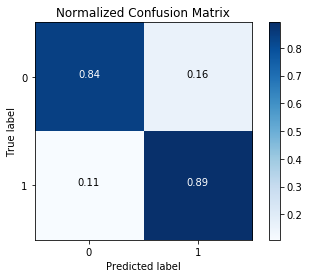

In [22]:
import itertools

cm = confusion_matrix(Y['label'],preds_bin)
cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]

plt.imshow(cm, cmap=plt.cm.Blues)
plt.title('Normalized Confusion Matrix')
plt.colorbar()
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.xticks([0, 1]); plt.yticks([0, 1])
plt.grid(False)
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], '.2f'),
             horizontalalignment='center',
             color='white' if cm[i, j] > 0.5 else 'black')

### Raw Confusion Matrix

Confusion matrix:
 [[777 148]
 [ 39 321]]


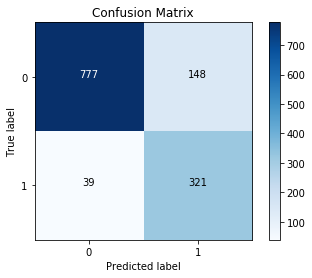

In [23]:
cm = confusion_matrix(Y['label'],preds_bin)
print('Confusion matrix:\n',cm)

plt.imshow(cm, cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.xticks([0, 1]); plt.yticks([0, 1])
plt.grid(False)
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j]),
             horizontalalignment='center',
             color='white' if cm[i, j] > 500 else 'black')

## Survival Analysis on Predictions

### Distant Relapse (DR)

<lifelines.StatisticalResult>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1

---
test_statistic      p  -log2(p)
         50.87 <0.005     39.88


None

Iteration 7: norm_delta = 0.00000, step_size = 1.0000, ll = -2322.50801, newton_decrement = 0.00000, seconds_since_start = 0.211Convergence completed after 7 iterations.
<lifelines.CoxPHFitter: fitted with 1285 observations, 931 censored>
      duration col = 'TDR'
         event col = 'DR'
number of subjects = 1285
  number of events = 354
partial log-likelihood = -2322.51
  time fit was run = 2019-06-12 03:27:35 UTC

---
                      coef exp(coef)  se(coef)    z      p  -log2(p)  lower 0.95  upper 0.95
preds_bin             0.58      1.79      0.11 5.11 <0.005     21.58        0.36        0.81
Age.At.Diagnosis      0.00      1.00      0.00 0.33   0.74      0.43       -0.01        0.01
Size                  0.02      1.02      0.00 7.24 <0.005     40.97        0.01        0.02
Lymph.Nodes.Positive  0.06      1.06      0.01 7.08 <0.005     39.38        0.04        0.07
Grade                 0.14      1.15      0.09 1.52   0.13      2.96       -0.04        0.32
---
Concordance

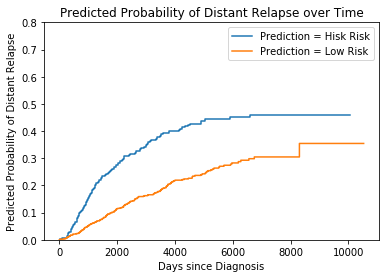

In [34]:
risk_ = [[],[]]
time_ = [[],[]]

for risk_type in (1, 0):
    mask_risk = preds_bin == risk_type
    time, survival_prob = kaplan_meier_estimator(
        Y['DR'][mask_risk],
        Y['TDR'][mask_risk])
    risk_[risk_type] = Y['DR'][mask_risk]
    time_[risk_type] = Y['TDR'][mask_risk]
    
    if risk_type:
        leg = "Hisk Risk"
    else:
        leg = "Low Risk"
    
    plt.step(time, 1 - survival_prob, where="post",
             label="Prediction = %s" % leg)

plt.ylabel("Predicted Probability of Distant Relapse")
plt.xlabel("Days since Diagnosis")
plt.title("Predicted Probability of Distant Relapse over Time")
plt.ylim([0.00, 0.8])
plt.legend(loc="best")

results = logrank_test(time_[0], time_[1], risk_[0], risk_[1])
display(results.print_summary())

cph = CoxPHFitter()
Y['preds'] = preds
Y['preds_bin'] = preds_bin
cph.fit(Y[['preds_bin','Age.At.Diagnosis','Size','Lymph.Nodes.Positive','Grade','DR','TDR']], duration_col='TDR', event_col='DR', show_progress=True)
cph.print_summary()

### Local Relapse (LR)

<lifelines.StatisticalResult>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1

---
test_statistic      p  -log2(p)
          8.30 <0.005      7.98


None

Iteration 7: norm_delta = 0.00000, step_size = 1.0000, ll = -1119.58511, newton_decrement = 0.00000, seconds_since_start = 0.10Convergence completed after 7 iterations.
<lifelines.CoxPHFitter: fitted with 1285 observations, 1115 censored>
      duration col = 'TLR'
         event col = 'LR'
number of subjects = 1285
  number of events = 170
partial log-likelihood = -1119.59
  time fit was run = 2019-06-12 02:24:41 UTC

---
                      coef exp(coef)  se(coef)     z      p  -log2(p)  lower 0.95  upper 0.95
preds_bin             0.37      1.44      0.17  2.18   0.03      5.11        0.04        0.69
Age.At.Diagnosis     -0.03      0.97      0.01 -4.03 <0.005     14.12       -0.04       -0.01
Size                  0.01      1.01      0.00  1.27   0.20      2.29       -0.00        0.02
Lymph.Nodes.Positive  0.05      1.06      0.01  4.17 <0.005     15.02        0.03        0.08
Grade                 0.12      1.13      0.13  0.92   0.36      1.48       -0.14        0.37
---
Conco

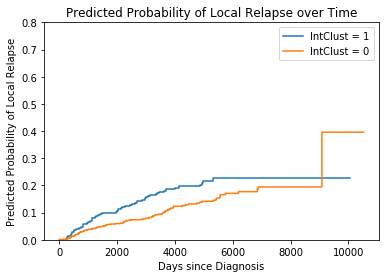

In [25]:
risk_ = [[],[]]
time_ = [[],[]]

for risk_type in (1, 0):
    mask_risk = preds_bin == risk_type
    time, survival_prob = kaplan_meier_estimator(
        Y['LR'][mask_risk],
        Y['TLR'][mask_risk])
    risk_[risk_type] = Y['LR'][mask_risk]
    time_[risk_type] = Y['TLR'][mask_risk]
    
    plt.step(time, 1 - survival_prob, where="post",
             label="IntClust = %s" % risk_type)

plt.ylabel("Predicted Probability of Local Relapse")
plt.xlabel("Days since Diagnosis")
plt.title("Predicted Probability of Local Relapse over Time")
plt.ylim([0.00, 0.8])
plt.legend(loc="best")

results = logrank_test(time_[0], time_[1], risk_[0], risk_[1])
display(results.print_summary())

cph = CoxPHFitter()
Y['preds'] = preds
Y['preds_bin'] = preds_bin
cph.fit(Y[['preds_bin','Age.At.Diagnosis','Size','Lymph.Nodes.Positive','Grade','LR','TLR']], duration_col='TLR', event_col='LR', show_progress=True)
cph.print_summary()

### Disease Specific Death (DSD)

<lifelines.StatisticalResult>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1

---
test_statistic      p  -log2(p)
         45.32 <0.005     35.80


None

Iteration 7: norm_delta = 0.00000, step_size = 1.0000, ll = -2376.16576, newton_decrement = 0.00000, seconds_since_start = 0.2.1Convergence completed after 7 iterations.
<lifelines.CoxPHFitter: fitted with 1285 observations, 912 censored>
      duration col = 'T'
         event col = 'DeathBreast'
number of subjects = 1285
  number of events = 373
partial log-likelihood = -2376.17
  time fit was run = 2019-06-12 02:24:41 UTC

---
                      coef exp(coef)  se(coef)    z      p  -log2(p)  lower 0.95  upper 0.95
preds_bin             0.49      1.64      0.11 4.42 <0.005     16.65        0.27        0.71
Age.At.Diagnosis      0.02      1.02      0.00 3.79 <0.005     12.71        0.01        0.03
Size                  0.02      1.02      0.00 7.07 <0.005     39.26        0.01        0.02
Lymph.Nodes.Positive  0.05      1.06      0.01 6.89 <0.005     37.43        0.04        0.07
Grade                 0.25      1.28      0.09 2.77   0.01      7.47        0.07        0.43
---
Conc

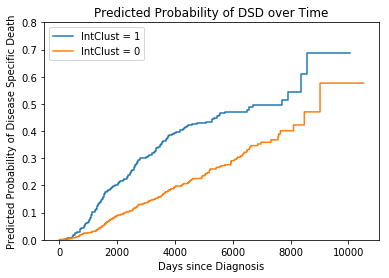

In [26]:
risk_ = [[],[]]
time_ = [[],[]]

for risk_type in (1, 0):
    mask_risk = preds_bin == risk_type
    time, survival_prob = kaplan_meier_estimator(
        Y['DeathBreast'][mask_risk],
        Y['T'][mask_risk])
    risk_[risk_type] = Y['DeathBreast'][mask_risk]
    time_[risk_type] = Y['T'][mask_risk]
    
    plt.step(time, 1 - survival_prob, where="post",
             label="IntClust = %s" % risk_type)

plt.ylabel("Predicted Probability of Disease Specific Death")
plt.xlabel("Days since Diagnosis")
plt.title("Predicted Probability of DSD over Time")
plt.ylim([0.00, 0.8])
plt.legend(loc="best")

results = logrank_test(time_[0], time_[1], risk_[0], risk_[1])
display(results.print_summary())

cph = CoxPHFitter()
Y['preds'] = preds
Y['preds_bin'] = preds_bin
cph.fit(Y[['preds_bin','Age.At.Diagnosis','Size','Lymph.Nodes.Positive','Grade','DeathBreast','T']], duration_col='T', event_col='DeathBreast', show_progress=True)
cph.print_summary()

### Local or Distant Relapse (LDR)

<lifelines.StatisticalResult>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1

---
test_statistic      p  -log2(p)
         35.64 <0.005     28.65


None

Iteration 7: norm_delta = 0.00000, step_size = 1.0000, ll = -2795.21721, newton_decrement = 0.00000, seconds_since_start = 0.21Convergence completed after 7 iterations.
<lifelines.CoxPHFitter: fitted with 1285 observations, 860 censored>
      duration col = 'TLDR'
         event col = 'LDR'
number of subjects = 1285
  number of events = 425
partial log-likelihood = -2795.22
  time fit was run = 2019-06-12 02:24:42 UTC

---
                      coef exp(coef)  se(coef)     z      p  -log2(p)  lower 0.95  upper 0.95
preds_bin             0.46      1.58      0.10  4.34 <0.005     16.10        0.25        0.66
Age.At.Diagnosis     -0.01      0.99      0.00 -1.73   0.08      3.59       -0.02        0.00
Size                  0.01      1.02      0.00  5.74 <0.005     26.68        0.01        0.02
Lymph.Nodes.Positive  0.05      1.06      0.01  6.91 <0.005     37.55        0.04        0.07
Grade                 0.11      1.11      0.08  1.30   0.19      2.37       -0.05        0.27
---
Conc

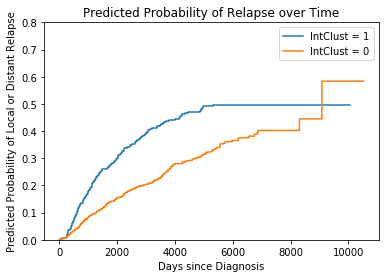

In [27]:
risk_ = [[],[]]
time_ = [[],[]]

for risk_type in (1, 0):
    mask_risk = preds_bin == risk_type
    time, survival_prob = kaplan_meier_estimator(
        Y['LDR'][mask_risk],
        Y['TLDR'][mask_risk])
    risk_[risk_type] = Y['LDR'][mask_risk]
    time_[risk_type] = Y['TLDR'][mask_risk]
    
    plt.step(time, 1 - survival_prob, where="post",
             label="IntClust = %s" % risk_type)

plt.ylabel("Predicted Probability of Local or Distant Relapse")
plt.xlabel("Days since Diagnosis")
plt.title("Predicted Probability of Relapse over Time")
plt.ylim([0.00, 0.8])
plt.legend(loc="best")

results = logrank_test(time_[0], time_[1], risk_[0], risk_[1])
display(results.print_summary())

cph = CoxPHFitter()
Y['preds'] = preds
Y['preds_bin'] = preds_bin
cph.fit(Y[['preds_bin','Age.At.Diagnosis','Size','Lymph.Nodes.Positive','Grade','LDR','TLDR']], duration_col='TLDR', event_col='LDR', show_progress=True)
cph.print_summary()

### Disease Specific Death or Distant Relapse (DDR)

<lifelines.StatisticalResult>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1

---
test_statistic      p  -log2(p)
         45.13 <0.005     35.66


None

Iteration 7: norm_delta = 0.00000, step_size = 1.0000, ll = -2765.67727, newton_decrement = 0.00000, seconds_since_start = 0.211Convergence completed after 7 iterations.
<lifelines.CoxPHFitter: fitted with 1285 observations, 859 censored>
      duration col = 'TDDR'
         event col = 'DDR'
number of subjects = 1285
  number of events = 426
partial log-likelihood = -2765.68
  time fit was run = 2019-06-12 02:24:42 UTC

---
                      coef exp(coef)  se(coef)    z      p  -log2(p)  lower 0.95  upper 0.95
preds_bin             0.46      1.58      0.10 4.41 <0.005     16.57        0.26        0.66
Age.At.Diagnosis      0.01      1.01      0.00 2.13   0.03      4.90        0.00        0.02
Size                  0.02      1.02      0.00 7.85 <0.005     47.75        0.01        0.02
Lymph.Nodes.Positive  0.06      1.06      0.01 7.68 <0.005     45.86        0.04        0.07
Grade                 0.18      1.19      0.08 2.12   0.03      4.89        0.01        0.34
---
Concordan

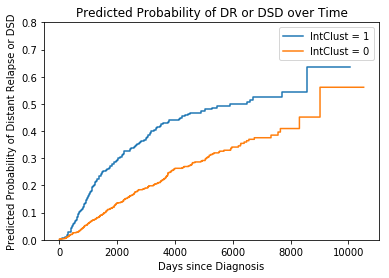

In [28]:
risk_ = [[],[]]
time_ = [[],[]]

for risk_type in (1, 0):
    mask_risk = preds_bin == risk_type
    time, survival_prob = kaplan_meier_estimator(
        Y['DDR'][mask_risk],
        Y['TDDR'][mask_risk])
    risk_[risk_type] = Y['DDR'][mask_risk]
    time_[risk_type] = Y['TDDR'][mask_risk]
    
    plt.step(time, 1 - survival_prob, where="post",
             label="IntClust = %s" % risk_type)

plt.ylabel("Predicted Probability of Distant Relapse or DSD")
plt.xlabel("Days since Diagnosis")
plt.title("Predicted Probability of DR or DSD over Time")
plt.ylim([0.00, 0.8])
plt.legend(loc="best")

results = logrank_test(time_[0], time_[1], risk_[0], risk_[1])
display(results.print_summary())

cph = CoxPHFitter()
Y['preds'] = preds
Y['preds_bin'] = preds_bin
cph.fit(Y[['preds_bin','Age.At.Diagnosis','Size','Lymph.Nodes.Positive','Grade','DDR','TDDR']], duration_col='TDDR', event_col='DDR', show_progress=True)
cph.print_summary()

### Disease Specific Death or Local Relapse (DLR)

<lifelines.StatisticalResult>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1

---
test_statistic      p  -log2(p)
         30.72 <0.005     25.00


None

Iteration 7: norm_delta = 0.00000, step_size = 1.0000, ll = -2911.10835, newton_decrement = 0.00000, seconds_since_start = 0.211Convergence completed after 7 iterations.
<lifelines.CoxPHFitter: fitted with 1285 observations, 834 censored>
      duration col = 'TDLR'
         event col = 'DLR'
number of subjects = 1285
  number of events = 451
partial log-likelihood = -2911.11
  time fit was run = 2019-06-12 02:24:43 UTC

---
                      coef exp(coef)  se(coef)    z      p  -log2(p)  lower 0.95  upper 0.95
preds_bin             0.38      1.46      0.10 3.71 <0.005     12.21        0.18        0.58
Age.At.Diagnosis      0.00      1.00      0.00 0.81   0.42      1.25       -0.00        0.01
Size                  0.01      1.01      0.00 5.54 <0.005     24.99        0.01        0.02
Lymph.Nodes.Positive  0.06      1.06      0.01 6.99 <0.005     38.41        0.04        0.07
Grade                 0.17      1.19      0.08 2.16   0.03      5.03        0.02        0.33
---
Concordan

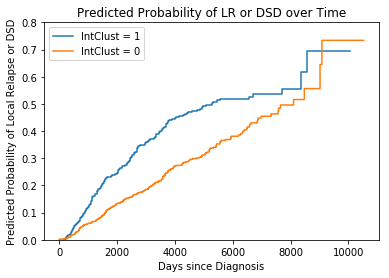

In [29]:
risk_ = [[],[]]
time_ = [[],[]]

for risk_type in (1, 0):
    mask_risk = preds_bin == risk_type
    time, survival_prob = kaplan_meier_estimator(
        Y['DLR'][mask_risk],
        Y['TDLR'][mask_risk])
    risk_[risk_type] = Y['DLR'][mask_risk]
    time_[risk_type] = Y['TDLR'][mask_risk]
    
    plt.step(time, 1 - survival_prob, where="post",
             label="IntClust = %s" % risk_type)

plt.ylabel("Predicted Probability of Local Relapse or DSD")
plt.xlabel("Days since Diagnosis")
plt.title("Predicted Probability of LR or DSD over Time")
plt.ylim([0.00, 0.8])
plt.legend(loc="best")

results = logrank_test(time_[0], time_[1], risk_[0], risk_[1])
display(results.print_summary())

cph = CoxPHFitter()
Y['preds'] = preds
Y['preds_bin'] = preds_bin
cph.fit(Y[['preds_bin','Age.At.Diagnosis','Size','Lymph.Nodes.Positive','Grade','DLR','TDLR']], duration_col='TDLR', event_col='DLR', show_progress=True)
cph.print_summary()

### Disease Specific Death or Local or Distant Relapse (DLDR)

<lifelines.StatisticalResult>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1

---
test_statistic      p  -log2(p)
         32.36 <0.005     26.22


None

Iteration 7: norm_delta = 0.00000, step_size = 1.0000, ll = -3194.21132, newton_decrement = 0.00000, seconds_since_start = 0.211Convergence completed after 7 iterations.
<lifelines.CoxPHFitter: fitted with 1285 observations, 795 censored>
      duration col = 'TDLDR'
         event col = 'DLDR'
number of subjects = 1285
  number of events = 490
partial log-likelihood = -3194.21
  time fit was run = 2019-06-12 02:24:43 UTC

---
                      coef exp(coef)  se(coef)     z      p  -log2(p)  lower 0.95  upper 0.95
preds_bin             0.37      1.45      0.10  3.81 <0.005     12.84        0.18        0.56
Age.At.Diagnosis     -0.00      1.00      0.00 -0.17   0.87      0.21       -0.01        0.01
Size                  0.02      1.02      0.00  6.25 <0.005     31.17        0.01        0.02
Lymph.Nodes.Positive  0.05      1.06      0.01  7.40 <0.005     42.72        0.04        0.07
Grade                 0.13      1.14      0.08  1.75   0.08      3.65       -0.02        0.28
---
C

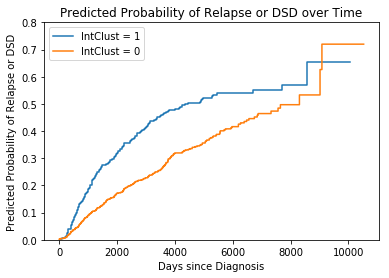

In [30]:
risk_ = [[],[]]
time_ = [[],[]]

for risk_type in (1, 0):
    mask_risk = preds_bin == risk_type
    time, survival_prob = kaplan_meier_estimator(
        Y['DLDR'][mask_risk],
        Y['TDLDR'][mask_risk])
    risk_[risk_type] = Y['DLDR'][mask_risk]
    time_[risk_type] = Y['TDLDR'][mask_risk]
    
    plt.step(time, 1 - survival_prob, where="post",
             label="IntClust = %s" % risk_type)

plt.ylabel("Predicted Probability of Relapse or DSD")
plt.xlabel("Days since Diagnosis")
plt.title("Predicted Probability of Relapse or DSD over Time")
plt.ylim([0.00, 0.8])
plt.legend(loc="best")

results = logrank_test(time_[0], time_[1], risk_[0], risk_[1])
display(results.print_summary())

cph = CoxPHFitter()
Y['preds'] = preds
Y['preds_bin'] = preds_bin
cph.fit(Y[['preds_bin','Age.At.Diagnosis','Size','Lymph.Nodes.Positive','Grade','DLDR','TDLDR']], duration_col='TDLDR', event_col='DLDR', show_progress=True)
cph.print_summary()

In [31]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

clinical_X = Y[['preds_bin','Age.At.Diagnosis','Size','Lymph.Nodes.Positive','Grade','DR','TDR']]

preds = np.zeros(clinical_X.shape[0])

f = 0
for train_index, test_index in cv.split(clinical_X, metabric_clinical['label']):
    X_train, X_test = clinical_X.iloc[train_index], clinical_X.iloc[test_index]
    X_test = X_test.drop('DR', axis=1)
    X_test = X_test.drop('TDR', axis=1)
    cph = CoxPHFitter()
    cph.fit(X_train, duration_col='TDR', event_col='DR')
    fold_preds = cph.predict_expectation(X_test)
    
    for i,j in zip(test_index,range(len(fold_preds))):
        preds[i] = fold_preds.iloc[j,0]
    
    f += 1
    print("Fold: \t", f)
    
c_index = concordance_index(clinical_X['TDR'], preds, clinical_X['DR'])
print(c_index)

Fold: 	 1
Fold: 	 2
Fold: 	 3
Fold: 	 4
Fold: 	 5
0.6874335244568872
